# Mining Segmentation Training Example (PyTorch)

This notebook demonstrates how to train and evaluate the UNet model for mining segmentation using PyTorch.

**Key Features:**
- Lazy-loaded dataset from Zarr (memory efficient)
- PyTorch-based training loop
- GPU/CPU device selection
- TensorBoard logging


## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from network.unet import build_unet
from network.train import MiningSegmentationTrainer
from network.evaluate import MiningSegmentationEvaluator
from network.config import NetworkConfig
from data.data_loader import MiningSegmentationDataLoader

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

PyTorch version: 2.10.0
CUDA available: False
Using CPU


## 1. Explore Available Data

In [2]:
# Initialize data loader to get statistics
# (We'll create actual dataset with filters later)
temp_loader = MiningSegmentationDataLoader()

# Get statistics
stats = temp_loader.get_statistics()

print(f"Total tiles available: {stats['total_tiles']}")
print(f"Number of bands: {stats['num_bands']}")
print(f"Bands: {stats['bands']}")
print(f"\nCountries: {stats['countries']}")
print(f"\nYears: {stats['years']}")
print(f"\nClusters: {stats['clusters']}")


2026-02-06 09:14:44,935 - data.data_loader - INFO - Using memory-mapped backend: C:\Users\schulz0022\Documents\mining-net\data\landsat_mmap
2026-02-06 09:14:45,018 - data.data_loader - INFO - Computing normalization statistics from 100 samples...
2026-02-06 09:14:45,841 - data.data_loader - INFO - Computed: means=['0.0486', '0.0795', '0.1087', '0.2156', '0.2528', '0.1882', '287.0908'], stds=['0.0203', '0.0316', '0.0523', '0.0734', '0.0960', '0.0860', '71.4012']
2026-02-06 09:14:45,841 - data.data_loader - INFO - Initialized dataset with 40449 tiles using memory-mapped backend
2026-02-06 09:14:45,842 - data.data_loader - INFO - Normalization enabled: True (precomputed: False)


Total tiles available: 40449
Number of bands: 7
Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']

Countries: {'ZAF': 40449}

Years: {2019: 40449}

Clusters: {4142974597563219461: 56, 2810147922030796186: 144, 861213725500306764: 224, 620024618185229339: 273, 52652953960301590: 100, 490904813412796749: 81, 3088462138954886185: 110, 3178341026490732864: 154, 474582821099989246: 110, 2495649146061856042: 90, 244620288433317774: 110, 71137107360758801: 208, 792192302790286003: 420, 4244490756375463389: 81, 1609785863007455954: 192, 1120695271374660330: 132, 731779548127895766: 3240, 4240845524073221692: 225, 322565366526356651: 144, 383509191624975320: 132, 3124267541868289849: 110, 153188716851427413: 132, 2178582057960825776: 266, 275433596250697125: 120, 2277217322999736006: 648, 1537026970642110959: 396, 3282992162223712662: 240, 1929385383236114867: 72, 17315396644879081: 110, 2408597752152204947: 81, 1448089678670666279: 64, 3245576156995732158: 90, 143119731707678

## 2. Load and Visualize Sample Data

In [3]:
# Create dataset with a specific year
dataset = MiningSegmentationDataLoader(years=[2019], normalize=False)
print(f"Tiles for 2019: {len(dataset)}")


2026-02-05 16:52:25,754 - data.data_loader - INFO - Using memory-mapped backend: C:\Users\schulz0022\Documents\mining-net\data\landsat_mmap
2026-02-05 16:52:25,815 - data.data_loader - INFO - Initialized dataset with 35652 tiles using memory-mapped backend
2026-02-05 16:52:25,815 - data.data_loader - INFO - Normalization enabled: False (precomputed: False)


Tiles for 2019: 35652


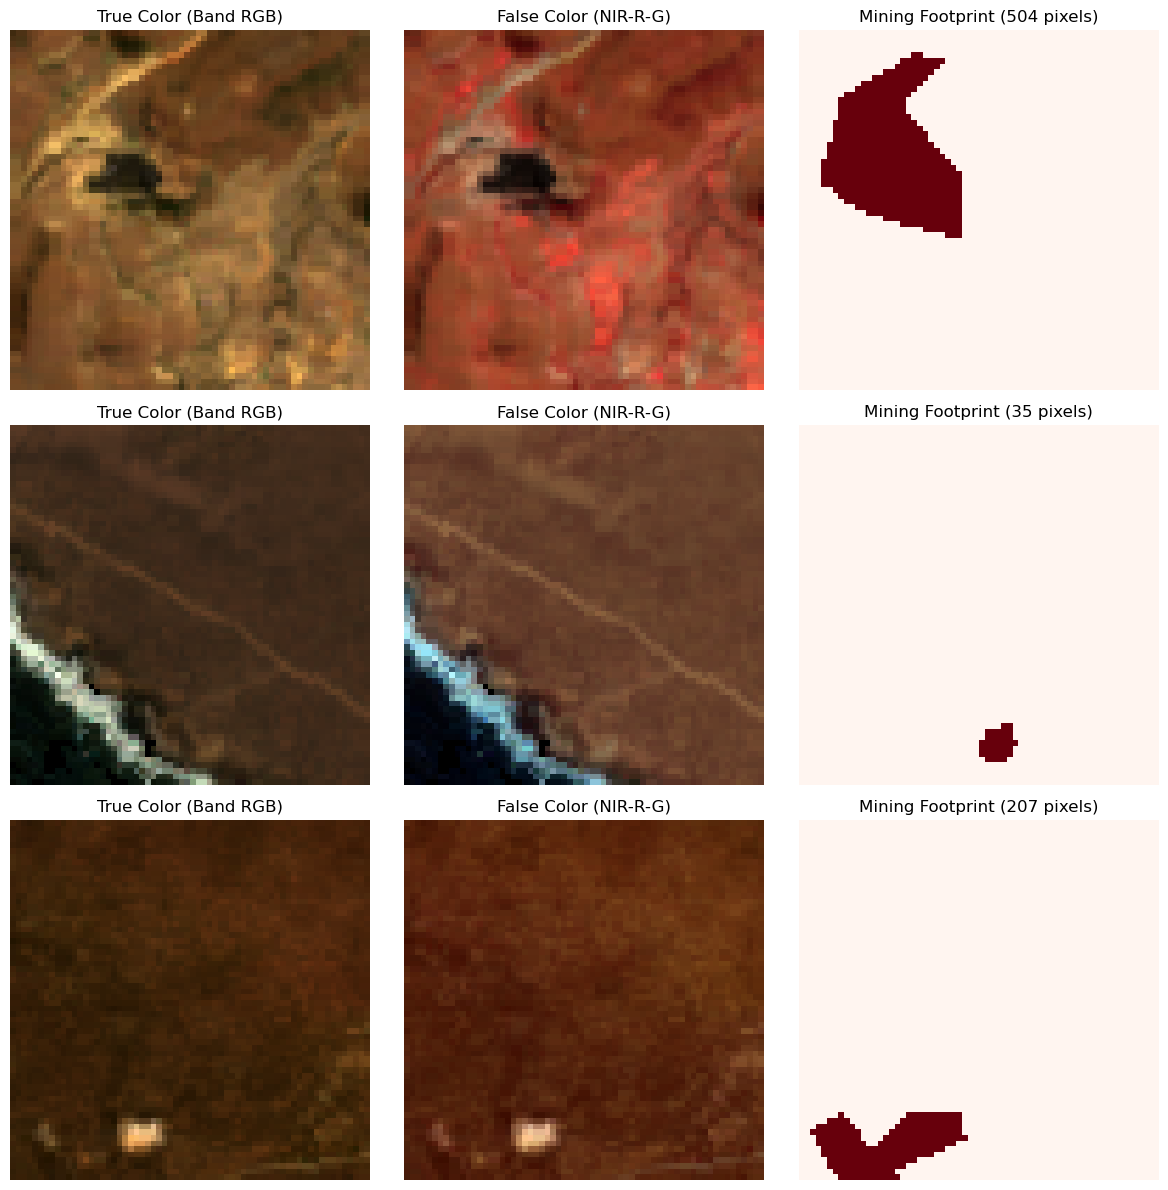

In [4]:
# Get some sample tiles from the dataset
num_samples = min(3, len(dataset))

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
if num_samples == 1:
    axes = axes[np.newaxis, :]

i = 0
idx = 0
while i < num_samples:
    # Load tile from dataset (returns torch tensors in C,H,W format)
    features_tensor, labels_tensor = dataset[idx]
    
    # Convert to numpy and transpose to H,W,C for visualization
    features = features_tensor.permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
    labels = labels_tensor.squeeze().numpy()  # (1,H,W) -> (H,W)

    if labels.sum() == 0:
        idx += 1
        continue
    
    # True color RGB (bands 2, 1, 0)
    rgb = features[:, :, [2, 1, 0]]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    axes[i, 0].imshow(rgb)
    axes[i, 0].set_title(f'True Color (Band RGB)')
    axes[i, 0].axis('off')
    
    # False color (NIR, Red, Green = bands 3, 2, 1)
    false_color = features[:, :, [3, 2, 1]]
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    axes[i, 1].imshow(false_color)
    axes[i, 1].set_title('False Color (NIR-R-G)')
    axes[i, 1].axis('off')
    
    # Mining footprint
    axes[i, 2].imshow(labels, cmap='Reds', vmin=0, vmax=1)
    axes[i, 2].set_title(f'Mining Footprint ({labels.sum():.0f} pixels)')
    axes[i, 2].axis('off')

    i += 1
    idx += 1

plt.tight_layout()
plt.show()

## 3. Build and Inspect Model

In [5]:
# Build model with PyTorch
model = build_unet(
    in_channels=7,
    num_classes=1,
    filters_base=64,
    depth=2,
    dropout_rate=0.1
)

print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


UNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv_block): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1

In [6]:
# Test forward pass with PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

test_input = torch.randn(2, 7, 64, 64).to(device)
with torch.no_grad():
    test_output = model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]")


Input shape: torch.Size([2, 7, 64, 64])
Output shape: torch.Size([2, 1, 64, 64])
Output range: [0.492, 0.506]


## 4. Configure Training

In [3]:
# Setup configuration
config = NetworkConfig()

# Adjust for quick testing (reduce for full training)
config.EPOCHS = 5
config.BATCH_SIZE = 16
config.EARLY_STOPPING_PATIENCE = 3
config.NUM_WORKERS = 0  # Set to 0 for Jupyter notebooks
config.PIN_MEMORY = False  # Set to False for Jupyter

# Loss and augmentation
config.LOSS_TYPE = 'combined'
config.USE_AUGMENTATION = True

# Device
config.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Input normalization (critical for convergence!)
# Uses per-sample normalization by default
# For best results, compute statistics first:
#   band_means, band_stds = dataset.compute_normalization_stats(max_samples=500)
#   config.BAND_MEANS = band_means
#   config.BAND_STDS = band_stds
config.NORMALIZE_INPUTS = True

# Display configuration
print("Training Configuration:")
print(f"  Device: {config.DEVICE}")
print(f"  Epochs: {config.EPOCHS}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Loss type: {config.LOSS_TYPE}")
print(f"  Augmentation: {config.USE_AUGMENTATION}")
print(f"  Normalization: {config.NORMALIZE_INPUTS}")
print(f"  Num workers: {config.NUM_WORKERS}")


Training Configuration:
  Device: cpu
  Epochs: 5
  Batch size: 16
  Learning rate: 0.001
  Loss type: combined
  Augmentation: True
  Normalization: True
  Num workers: 0


## 5. Train Model

2026-02-05 17:05:37,372 - network.train - INFO - Using CPU
2026-02-05 17:05:37,373 - network.train - INFO - Building UNet model...
2026-02-05 17:05:37,447 - network.train - INFO - Total parameters: 31,045,825
2026-02-05 17:05:37,448 - network.train - INFO - Trainable parameters: 31,045,825
2026-02-05 17:05:37,448 - network.train - INFO - Creating datasets...
2026-02-05 17:05:37,451 - data.data_loader - INFO - Using memory-mapped backend: C:\Users\schulz0022\Documents\mining-net\data\landsat_mmap
2026-02-05 17:05:37,501 - data.data_loader - INFO - Computing normalization statistics from 100 samples...
2026-02-05 17:05:38,395 - data.data_loader - INFO - Computed: means=['0.0486', '0.0791', '0.1093', '0.2042', '0.2551', '0.1903', '285.9827'], stds=['0.0214', '0.0346', '0.0592', '0.0843', '0.1129', '0.0948', '72.0646']
2026-02-05 17:05:38,395 - data.data_loader - INFO - Initialized dataset with 34580 tiles using memory-mapped backend
2026-02-05 17:05:38,395 - data.data_loader - INFO - Norm

Training history plot saved to c:\Users\schulz0022\Documents\mining-net\models\checkpoints\mining_unet_demo\training_history.png


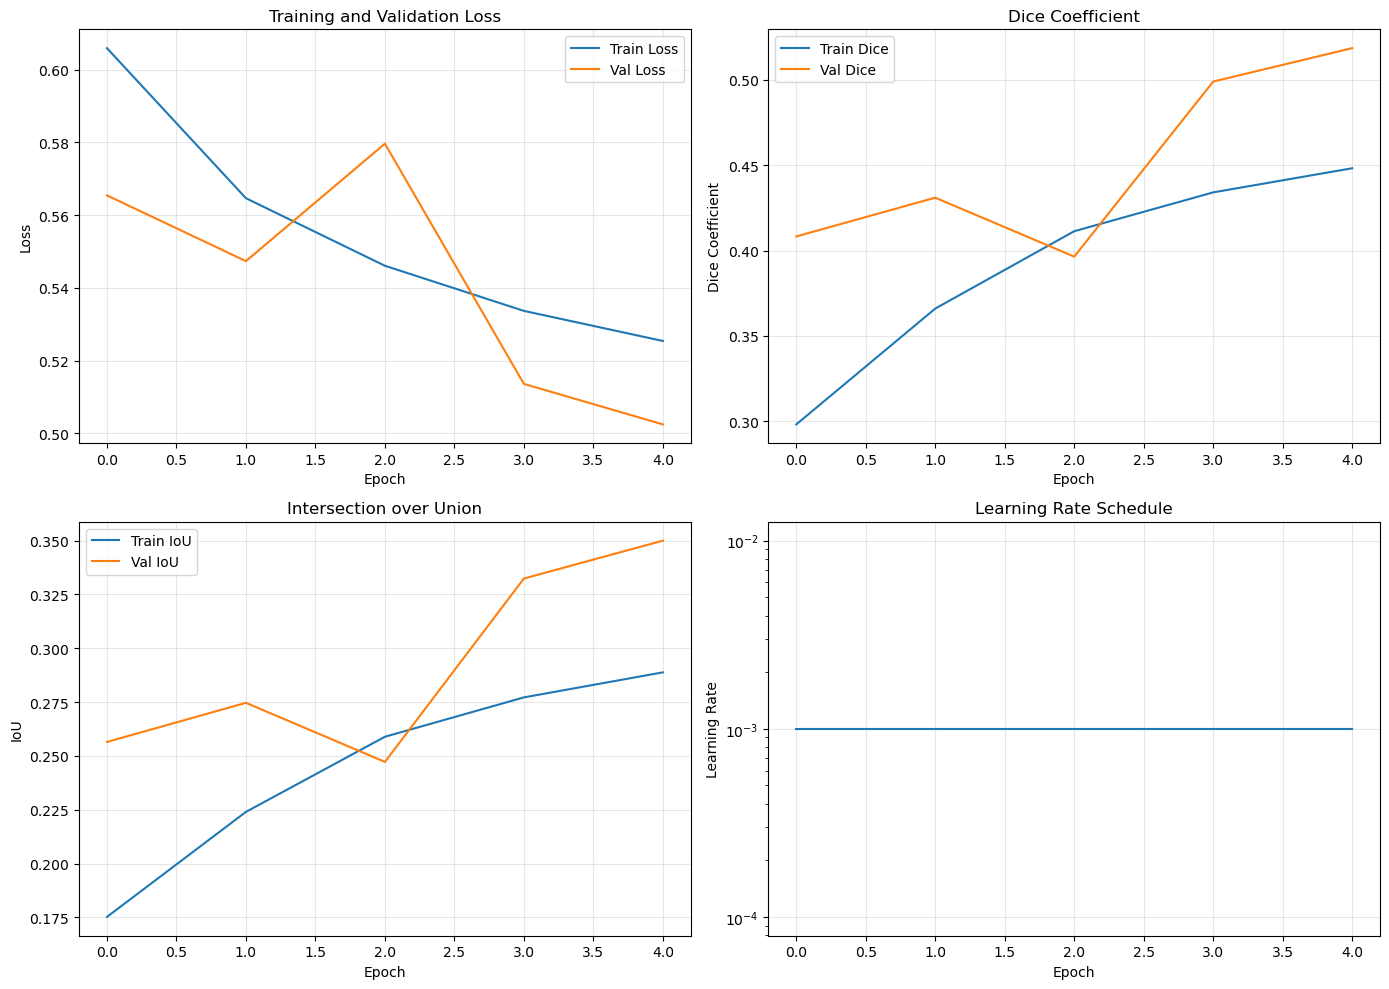


Training completed!


In [14]:
# Initialize trainer
trainer = MiningSegmentationTrainer(network_config=config)

# Train model (adjust filters as needed for available data)
# Using a small subset for this demo
try:
    history = trainer.train(
        years=[2019],
        run_name='mining_unet_demo'
    )
    print("\nTraining completed!")
except Exception as e:
    print(f"Training stopped (this is expected in a limited demo): {e}")


## 6. Evaluate Model

In [5]:
# Find the best checkpoint from training
checkpoint_dir = config.CHECKPOINT_DIR / 'mining_unet_demo'
best_checkpoint = checkpoint_dir / 'best_model.pth'

if best_checkpoint.exists():
    # Initialize evaluator with the trained model
    evaluator = MiningSegmentationEvaluator(str(best_checkpoint), network_config=config)
    
    # Evaluate on validation data
    try:
        results = evaluator.evaluate(
            years=[2019],
            batch_size=16
        )
        
        print("\nEvaluation Results:")
        for metric, value in results.items():
            print(f"  {metric}: {value:.4f}")
    except Exception as e:
        print(f"Evaluation note: {e}")
else:
    print(f"No checkpoint found at {best_checkpoint}")
    print("Train a model first or verify the checkpoint path")


2026-02-06 09:14:54,663 - network.evaluate - INFO - Using CPU
2026-02-06 09:14:54,664 - network.evaluate - INFO - Building model...
2026-02-06 09:14:54,744 - network.evaluate - INFO - Loading weights from c:\Users\schulz0022\Documents\mining-net\models\checkpoints\mining_unet_demo\best_model.pth
2026-02-06 09:14:54,880 - network.evaluate - INFO - Model loaded successfully
2026-02-06 09:14:54,881 - network.evaluate - INFO - Starting evaluation...
2026-02-06 09:14:54,883 - data.data_loader - INFO - Using memory-mapped backend: C:\Users\schulz0022\Documents\mining-net\data\landsat_mmap
2026-02-06 09:14:54,986 - data.data_loader - INFO - Computing normalization statistics from 100 samples...
2026-02-06 09:14:55,857 - data.data_loader - INFO - Computed: means=['0.0534', '0.0892', '0.1281', '0.2327', '0.2894', '0.2210', '296.7088'], stds=['0.0187', '0.0308', '0.0540', '0.0563', '0.0832', '0.0817', '53.7459']
2026-02-06 09:14:55,857 - data.data_loader - INFO - Initialized dataset with 40449 t

KeyboardInterrupt: 

## 7. Visualize Predictions

2026-02-06 09:16:13,431 - network.evaluate - INFO - Generating visualizations for 10 samples...
2026-02-06 09:16:13,433 - data.data_loader - INFO - Using memory-mapped backend: C:\Users\schulz0022\Documents\mining-net\data\landsat_mmap
2026-02-06 09:16:13,500 - data.data_loader - INFO - Computing normalization statistics from 100 samples...
2026-02-06 09:16:14,349 - data.data_loader - INFO - Computed: means=['0.0474', '0.0776', '0.1070', '0.2054', '0.2474', '0.1848', '287.7823'], stds=['0.0227', '0.0353', '0.0592', '0.0832', '0.1112', '0.0957', '68.7998']
2026-02-06 09:16:14,350 - data.data_loader - INFO - Initialized dataset with 40449 tiles using memory-mapped backend
2026-02-06 09:16:14,350 - data.data_loader - INFO - Normalization enabled: True (precomputed: False)


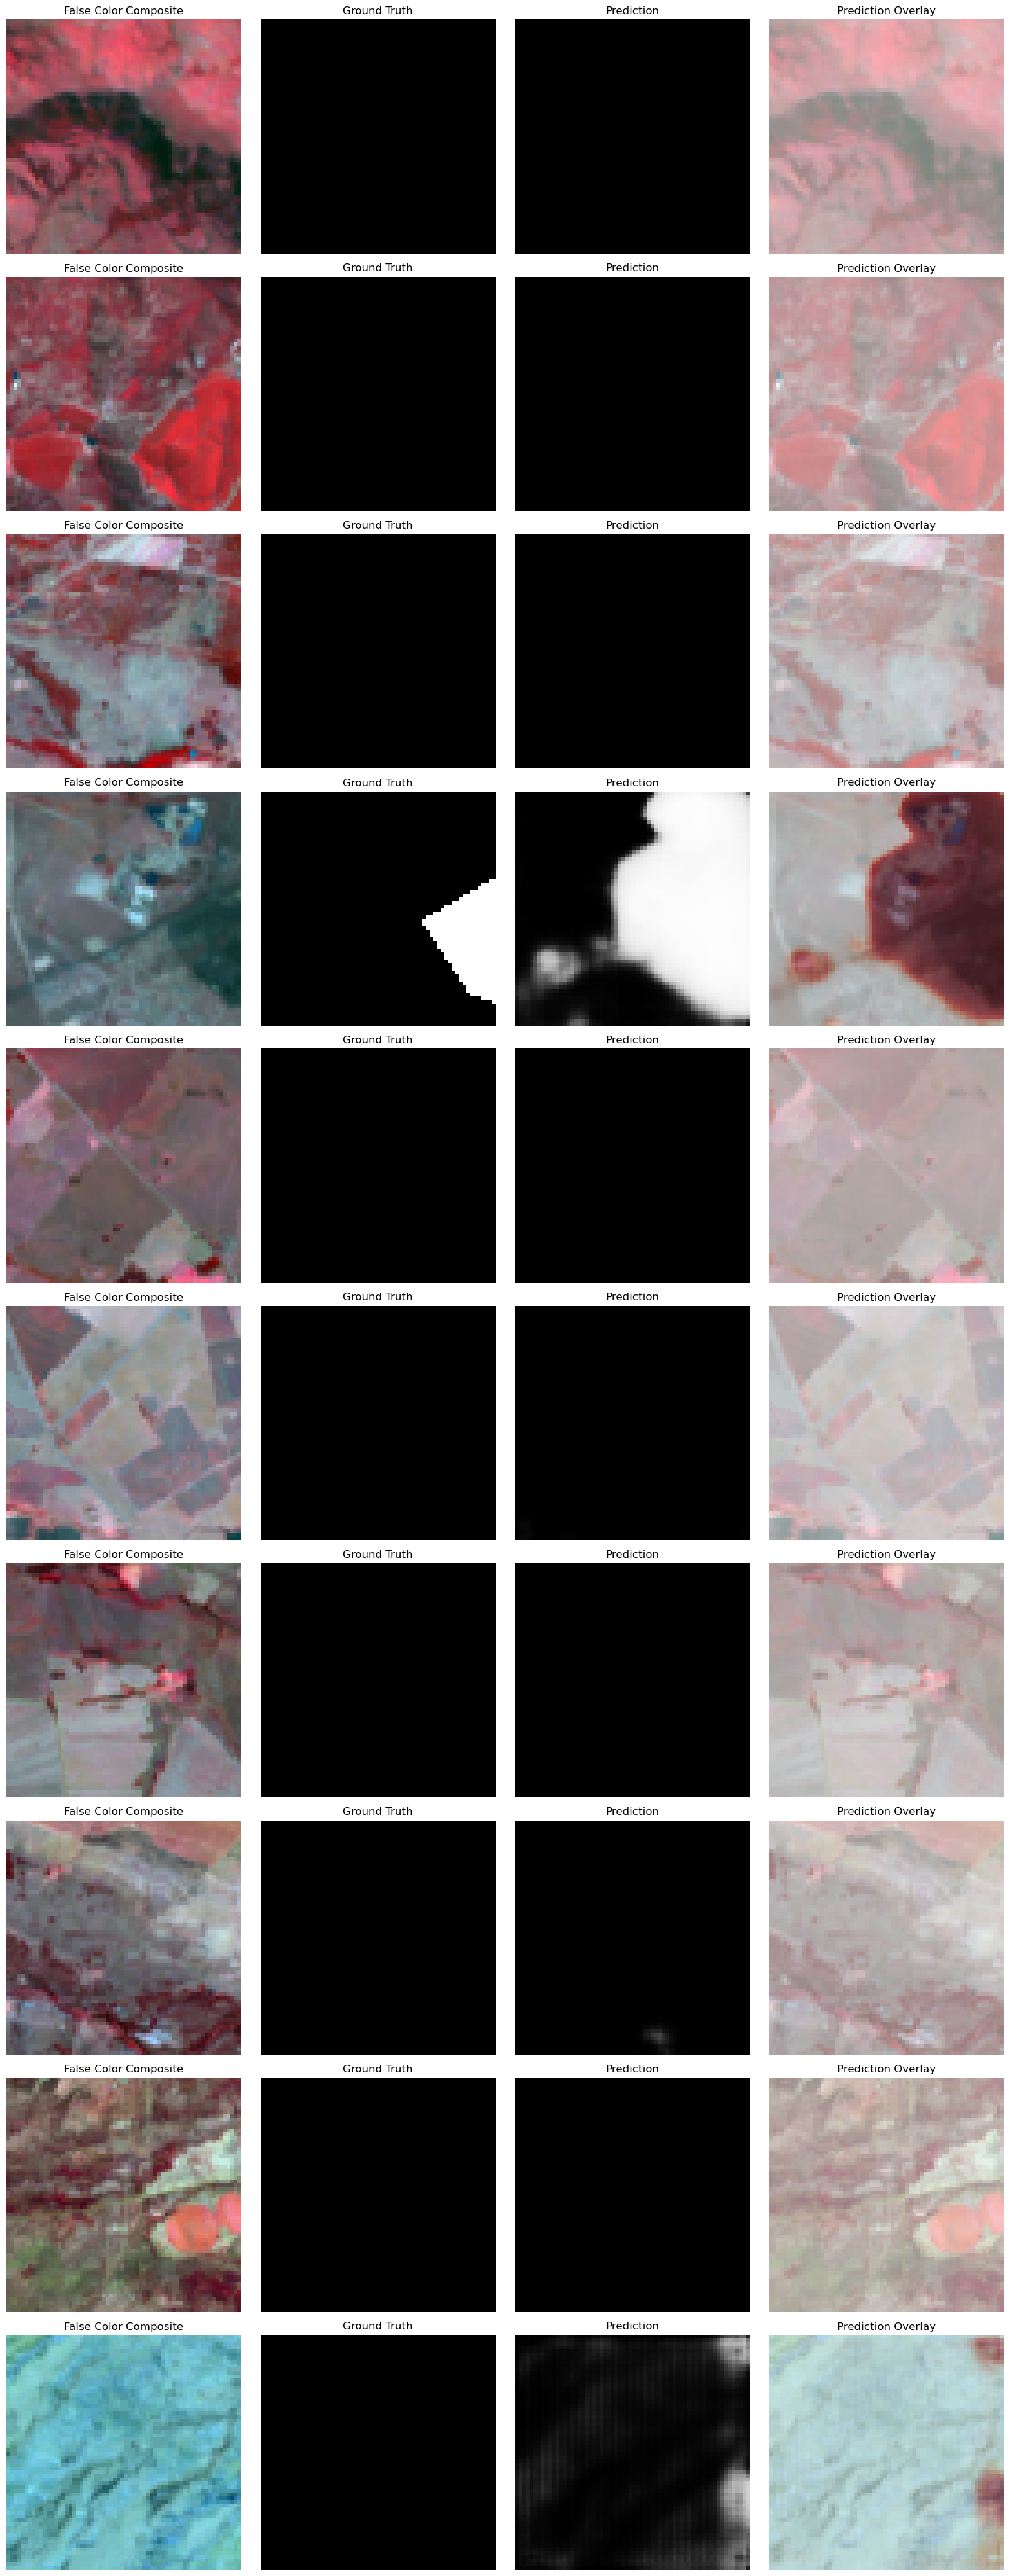

2026-02-06 09:16:15,722 - network.evaluate - INFO - Visualization completed!


In [8]:
# Visualize predictions on sample tiles if model exists
if best_checkpoint.exists():
    try:
        evaluator.visualize_predictions(
            years=[2019],
            num_samples=10
        )
    except Exception as e:
        print(f"Visualization note: {e}")
else:
    print("Train a model first to visualize predictions")


## 8. Predict on Individual Tiles

In [ ]:
# Get a test tile and predict
if best_checkpoint.exists() and len(dataset) > 0:
    # Get first tile from dataset
    features_tensor, labels_tensor = dataset[0]
    
    # Get predictions
    features, ground_truth, prediction = evaluator.predict_tile(
        dataset.tiles[0]['tile_ix'],
        dataset.tiles[0]['tile_iy']
    )
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # False color composite
    false_color = features[:, :, [3, 2, 1]]  # NIR, Red, Green
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    axes[0].imshow(false_color)
    axes[0].set_title('False Color Composite')
    axes[0].axis('off')
    
    # Ground truth
    axes[1].imshow(ground_truth, cmap='Reds', vmin=0, vmax=1)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    
    # Prediction (probability)
    axes[2].imshow(prediction, cmap='Reds', vmin=0, vmax=1)
    axes[2].set_title('Prediction (Probability)')
    axes[2].axis('off')
    
    # Overlay
    axes[3].imshow(false_color)
    axes[3].imshow(prediction, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
    axes[3].set_title('Prediction Overlay')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Compute metrics for this tile
    pred_binary = (prediction > 0.5).astype(float)
    intersection = (ground_truth * pred_binary).sum()
    union = ground_truth.sum() + pred_binary.sum() - intersection
    iou = intersection / (union + 1e-8)
    dice = 2 * intersection / (ground_truth.sum() + pred_binary.sum() + 1e-8)
    
    print(f"\nTile Metrics:")
    print(f"  IoU: {iou:.4f}")
    print(f"  Dice: {dice:.4f}")
    print(f"  Ground truth pixels: {ground_truth.sum():.0f}")
    print(f"  Predicted pixels: {pred_binary.sum():.0f}")
else:
    print("Train a model first or ensure dataset has tiles")


## 9. Export Predictions (Optional)

In [ ]:
# Uncomment to export all predictions
# if best_checkpoint.exists():
#     evaluator.export_predictions(
#         years=[2019],
#         output_dir='predictions/',
#         threshold=0.5
#     )
# else:
#     print("Train a model first to export predictions")
